# Vannishing Grad, sadly

In [1]:
import numpy as np
import struct,os
from array import array as pyarray
from numpy import append, array, int8, uint8, zeros
import torch

def load_mnist(image_file, label_file):
    digits=np.arange(10)

    fname_image = os.path.join("../"+image_file)
    fname_label = os.path.join("../"+label_file)

    flbl = open(fname_label, 'rb')
    magic_nr, size = struct.unpack(">II", flbl.read(8))
    lbl = pyarray("b", flbl.read())
    flbl.close()

    fimg = open(fname_image, 'rb')
    magic_nr, size, rows, cols = struct.unpack(">IIII", fimg.read(16))
    img = pyarray("B", fimg.read())
    fimg.close()

    ind = [ k for k in range(size) if lbl[k] in digits ]
    N = len(ind)

    images = zeros((N, rows*cols), dtype=uint8)
    labels = zeros((N, 1), dtype=int8)
    for i in range(len(ind)):
        images[i] = array(img[ ind[i]*rows*cols : (ind[i]+1)*rows*cols ]).reshape((1, rows*cols))
        labels[i] = lbl[ind[i]]

    return images, labels

train_image, train_label = load_mnist("train-images.idx3-ubyte", "train-labels.idx1-ubyte")
test_image, test_label = load_mnist("t10k-images.idx3-ubyte", "t10k-labels.idx1-ubyte")


In [2]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
#device ='cpu'
layers=4
lsize=[train_image.shape[1],17*17,16*16,15*15,10]

W=[(torch.randn(lsize[i],lsize[i+1],dtype=torch.float32)*(1/lsize[i])).to(device) for i in range(layers)]
b=[torch.randn(lsize[i],dtype=torch.float32).to(device) for i in range(1,layers+1)]

ty=torch.zeros([train_image.shape[0],lsize[len(lsize)-1]],dtype=torch.float32).to(device)
for i in range(train_image.shape[0]):
    ty[i][train_label[i].item()]=1.0

In [3]:
print("W's shape is")
for i in range(len(W)):
    print(W[i].shape)
print("b's shape is")
for i in range(len(b)):
    print(b[i].shape)

W's shape is
torch.Size([784, 289])
torch.Size([289, 256])
torch.Size([256, 225])
torch.Size([225, 10])
b's shape is
torch.Size([289])
torch.Size([256])
torch.Size([225])
torch.Size([10])


In [4]:
# device = 'cuda' if torch.cuda.is_available() else 'cpu'
train_image=torch.from_numpy(train_image).float().to(device)
train_label=torch.from_numpy(train_label).int().to(device)
test_image=torch.from_numpy(test_image).float().to(device)
test_label=torch.from_numpy(test_label).int().to(device)

In [29]:
m = torch.nn.Sigmoid()
A=[]
def predict(img):
    A.clear()
    A.append(m(img@W[0]+b[0]))
    for i in range(layers-1):
        A.append(m(A[i]@W[i+1]+b[i+1]))
    return A[len(A)-1]

In [8]:
print("A's shape is")
for i in range(len(A)):
    print(A[i].shape)

A's shape is
torch.Size([60000, 289])
torch.Size([60000, 256])
torch.Size([60000, 225])
torch.Size([60000, 10])


In [131]:
def train_accu():
    err=0
    Y=torch.argmax(predict(train_image),dim=1)
    for i in range(Y.shape[0]):
        if(Y[i]!=train_label[i]):
            err+=1
    return (1-err/train_image.shape[0])
print("%.10lf"%train_accu())

0.6083666667


In [130]:
def genaralization_accu():
    err=0
    Y=torch.argmax(predict(test_image),dim=1)
    for i in range(Y.shape[0]):
        if(Y[i]!=test_label[i]):
            err+=1
    return (1-err/test_image.shape[0])
print("%.10lf"%genaralization_accu())

0.5935000000


In [129]:
def loss():
    tmp=(predict(train_image)-ty)
    # print((tmp*tmp).shape)
    return (tmp*tmp).sum().item()
print(loss())

23573.42578125


In [41]:
torch.set_printoptions(precision=10)

In [134]:
db=torch.load("model_all_sigmoid.pth")
for i in range(layers):
    W[i]=db["W"+str(i)]
for i in range(layers):
    b[i]=db["b"+str(i)]

In [ ]:
alpha=0.000003
T=18000*3
pre_loss=1e9
pre_t_accu=1e9
while T>0:
    predict(train_image)
    dlt=[]
    n=len(A)-1
    dlt.append((A[n]-ty)*A[n]*(1-A[n])) #g dlt[1]
    for i in range(layers-1,0,-1):
        dlt.append((dlt[layers-i-1]@W[i].T)*A[i-1]*(1-A[i-1])) #e dlt[0]
    dlt.reverse()
    W[0]-=alpha*(train_image.T)@dlt[0]
    # print(dlt[0].sum(axis=0).shape)
    b[0]-=alpha*dlt[0].sum(axis=0)
    for i in range(1,layers):
        W[i]-=alpha*(A[i-1].T)@dlt[i]
        # print(dlt[i].sum(axis=0).shape)
        b[i]-=alpha*dlt[i].sum(axis=0)
    T-=1
    dlt.clear()
    if(T%40==0):
        # print_train_error()
        now_loss=loss()
        print(loss())
        if(now_loss-pre_loss>20):
            #break
            alpha/=3
            print("!!!!!!! alpha to "+str(alpha))
        elif(pre_loss-now_loss<0.1):
            alpha=min(0.000006,1.1*alpha)
            print("### alpha to "+str(alpha))
        pre_loss=now_loss
        # print(b[3])
    if(T%2000==0):
        now_t_accu=genaralization_accu()
        print(now_t_accu)
        if(pre_t_accu<now_t_accu and now_t_accu>0.9):
            break
        pre_t_accu=now_t_accu
        alpha=min(0.000006,1.1*alpha)
        print("?? alpha to "+str(alpha))
    

In [13]:
for i in range(len(dlt)):
    print(dlt[i].shape)

In [137]:
def save_model():
    db=dict()
    for i in range(layers):
        db["W"+str(i)]=W[i]
    for i in range(layers):
        db["b"+str(i)]=b[i]
    torch.save(db,"model_all_sigmoid.pth")
save_model()

0:980/980=1.0000000000
1:21/1135=0.0185022026
2:52/1032=0.0503875969
3:35/1010=0.0346534653
4:982/982=1.0000000000
5:892/892=1.0000000000
6:14/958=0.0146137787
7:59/1028=0.0573929961
8:24/974=0.0246406571
9:1009/1009=1.0000000000


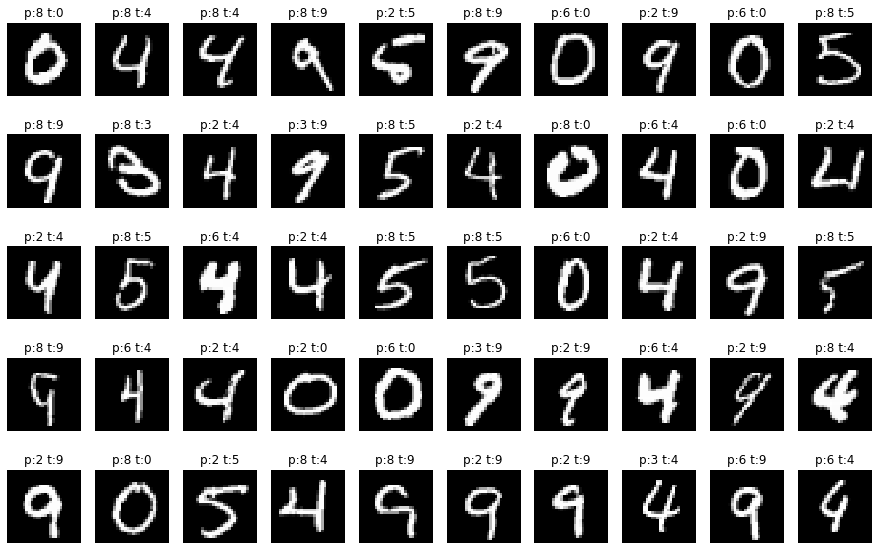

In [138]:
from matplotlib import pyplot as plt
err=0
sum=[0 for i in range(10)]
ecnt=[0 for i in range(10)]
Y=torch.argmax(predict(test_image),dim=1)
for i in range(Y.shape[0]):
    sum[test_label[i]]+=1
    if(Y[i]!=test_label[i]):
        err+=1
        ecnt[test_label[i]]+=1
        if err<=50:
            plt.subplots_adjust(left=1, bottom=None, right=3, top=2, wspace=None, hspace=None)
            plt.subplot(5, 10, err)
            plt.axis('off')
            img=np.array(list(test_image[i].cpu())).reshape(28,-1)
            plt.imshow(img, cmap='gray',interpolation='nearest')
            plt.title("p:%d t:%d"% (Y[i],test_label[i]))
for i in range(len(sum)):
    print("%d:%d/%d=%.10lf"%(i,ecnt[i],sum[i],ecnt[i]/sum[i]))

In [ ]:
db=torch.load("../PyTorchNN/trained_model_tensor2.pt")
W[0]=db["v"]
W[1]=db["w"]
b[0]=-db["gamma"]
b[1]=-db["theta"]